# Erstellen einer Umsatzprognose
© Thomas Robert Holy 2019
<br>
Version 0.0.2
<br><br>
Visit me on GitHub: https://github.com/trh0ly

## Import Packages

In [1]:
#----------------
# Web Scrap
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import re
import string

#----------------
# Forecast
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
import statsmodels.api as sm

#----------------
# Verschiedenes
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import chart_studio.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline  
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import datetime

## Optikeinstellungen

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.width', 350)
plt.rcParams['figure.figsize'] = (24, 12) # macht die Plots größer

## Datenbeschaffung und Manipulation
### Web Scrap historischer Daten von Statista

In [4]:
"""
#url = 'https://www.statista.com/statistics/273963/quarterly-revenue-of-amazoncom/' # Amazon
#url = 'https://www.statista.com/statistics/263427/apples-net-income-since-first-quarter-2005/' # Apple
url = 'https://www.statista.com/statistics/323046/alibaba-quarterly-group-revenue/' # Alibaba

html = requests.get(url)
soup = BeautifulSoup(html.text, 'lxml')

chart = soup.find("tbody")
children = chart.find_all("tr")

data = []
for tag in children:
    data_tuple = (tag.text[:6],tag.text[6:])
    data.append(data_tuple)

quartals, revenues = [], []
for i in range(0, len(data)):
    x = data[i][0]
    y = data[i][1]
    quartal = x.replace(' ', '')
    y = y.replace(',', '.')
    revenue = float(y)
    quartals.append(quartal)
    revenues.append(revenue)

quartals = quartals[::-1]
revenues = revenues[::-1]
print(quartals)
print(revenues)
"""

'\n#url = \'https://www.statista.com/statistics/273963/quarterly-revenue-of-amazoncom/\' # Amazon\n#url = \'https://www.statista.com/statistics/263427/apples-net-income-since-first-quarter-2005/\' # Apple\nurl = \'https://www.statista.com/statistics/323046/alibaba-quarterly-group-revenue/\' # Alibaba\n\nhtml = requests.get(url)\nsoup = BeautifulSoup(html.text, \'lxml\')\n\nchart = soup.find("tbody")\nchildren = chart.find_all("tr")\n\ndata = []\nfor tag in children:\n    data_tuple = (tag.text[:6],tag.text[6:])\n    data.append(data_tuple)\n\nquartals, revenues = [], []\nfor i in range(0, len(data)):\n    x = data[i][0]\n    y = data[i][1]\n    quartal = x.replace(\' \', \'\')\n    y = y.replace(\',\', \'.\')\n    revenue = float(y)\n    quartals.append(quartal)\n    revenues.append(revenue)\n\nquartals = quartals[::-1]\nrevenues = revenues[::-1]\nprint(quartals)\nprint(revenues)\n'

### DataFrame mit den Daten erzeugen und Überprüfen

In [5]:
#----------------------------------------
# Daten als Array manuell gespeichert 

#-----------------------
# Apple

quartals = ["Q1'05", "Q2'05", "Q3'05", "Q4'05", "Q1'06", "Q2'06", "Q3'06", "Q4'06", "Q1'07", "Q2'07", "Q3'07",
            "Q4'07", "Q1'08", "Q2'08", "Q3'08", "Q4'08", "Q1'09", "Q2'09", "Q3'09", "Q4'09", "Q1'10", "Q2'10",
            "Q3'10", "Q4'10", "Q1'11", "Q2'11", "Q3'11", "Q4'11", "Q1'12", "Q2'12", "Q3'12", "Q4'12", "Q1'13",
            "Q2'13", "Q3'13", "Q4'13", "Q1'14", "Q2'14", "Q3'14", "Q4'14", "Q1'15", "Q2'15", "Q3'15", "Q4'15",
            "Q1'16", "Q2'16", "Q3'16", "Q4'16", "Q1'17", "Q2'17", "Q3'17", "Q4'17", "Q1'18", "Q2'18", "Q3'18",
            "Q4'18", "Q1'19", "Q2'19", "Q3'19", "Q4'19"]

revenues = [0.3, 0.29, 0.32, 0.43, 0.57, 0.41, 0.47, 0.55, 1.01, 0.77, 0.84, 0.87, 1.64, 1.1, 1.13, 2.25, 2.26,
            1.62, 1.82, 2.53, 3.38, 3.07, 3.25, 4.31, 6.0, 5.99, 7.31, 6.62, 13.06, 11.62, 8.82, 8.22, 13.1, 9.55,
            6.9, 7.5, 13.07, 10.22, 7.75, 8.47, 18.02, 13.57, 10.68, 11.12, 18.36, 10.52, 7.8, 9.01, 17.89, 11.03,
            8.72, 10.71, 20.07, 13.82, 11.52, 14.13, 19.97, 11.56, 10.04, 13.69]

print(len(quartals))
print(len(revenues))

#----------------------------------------
# Logarithmus anwenden
revenues = np.log(revenues)

#----------------------------------------
# Quartale umbenennen 
quartals_new = []
for i in quartals:
    x = '20' + str(i[3:])
    y = i[:2]
    z = str(x) + '-' + str(y)
    quartals_new.append(z)
    
#----------------------------------------
# DataFrame mit bereinigten Daten erzeugen
original_data = pd.DataFrame({'Periode':quartals_new, 'Umsatz':revenues})
original_data['Periode'] = pd.to_datetime(original_data['Periode'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')
original_data.isnull().sum()

60
60


Periode    0
Umsatz     0
dtype: int64

## Visualisierung des DataFrames

,Periode,Umsatz
52,2018-01-01,2.999226
53,2018-04-01,2.626117
54,2018-07-01,2.444085
55,2018-10-01,2.648300
56,2019-01-01,2.994231
57,2019-04-01,2.447551
58,2019-07-01,2.306577
59,2019-10-01,2.616666


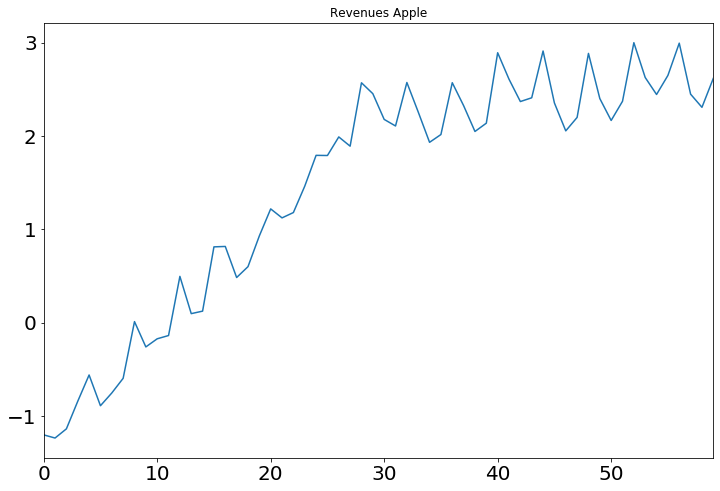

In [6]:
original_data.Umsatz.plot(figsize=(12,8), title= 'Revenues Apple', fontsize=20)
original_data.tail(8)

## Zerlegung der Zeitreihe in einzelne Komponenten

<Figure size 1728x864 with 0 Axes>

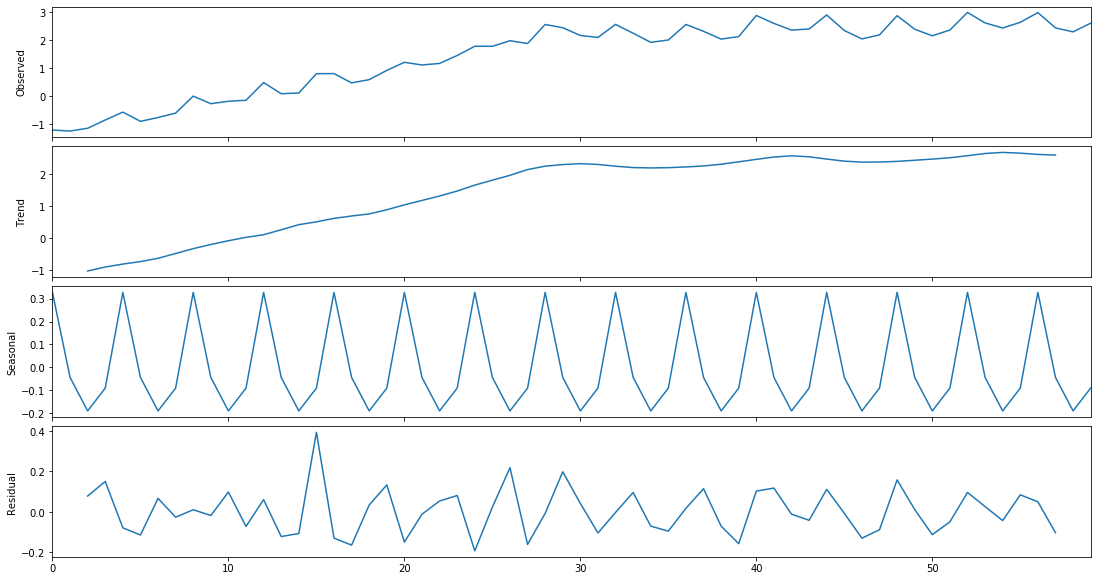

In [7]:
decomposition = seasonal_decompose(original_data.Umsatz, freq=4)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Test- und Trainingsdatensatz erstellen

In [8]:
#----------------------------------------
# Test-Datensatz
test_df = original_data.tail(6)
test_df = test_df.drop('Umsatz', axis=1)
test_df.head(6)

,Periode
54,2018-07-01
55,2018-10-01
56,2019-01-01
57,2019-04-01
58,2019-07-01
59,2019-10-01


In [9]:
#----------------------------------------
# Trainings-Datensatz
train_df = original_data.copy(deep=True)
train_df.drop(train_df.tail(6).index,inplace=True)
train_df.tail(6)

,Periode,Umsatz
48,2017-01-01,2.884242
49,2017-04-01,2.400619
50,2017-07-01,2.165619
51,2017-10-01,2.371178
52,2018-01-01,2.999226
53,2018-04-01,2.626117


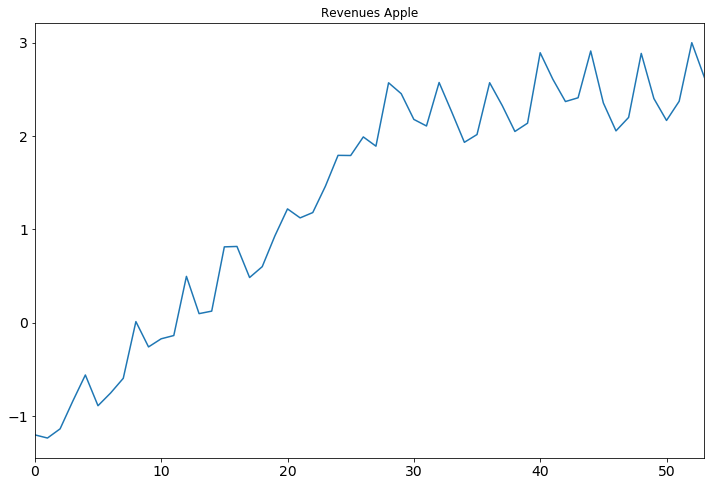

In [10]:
train_df.Umsatz.plot(figsize=(12,8), title= 'Revenues Apple', fontsize=14)

## Visuelle Überprüfung der Zeitreihe auf Stationarität

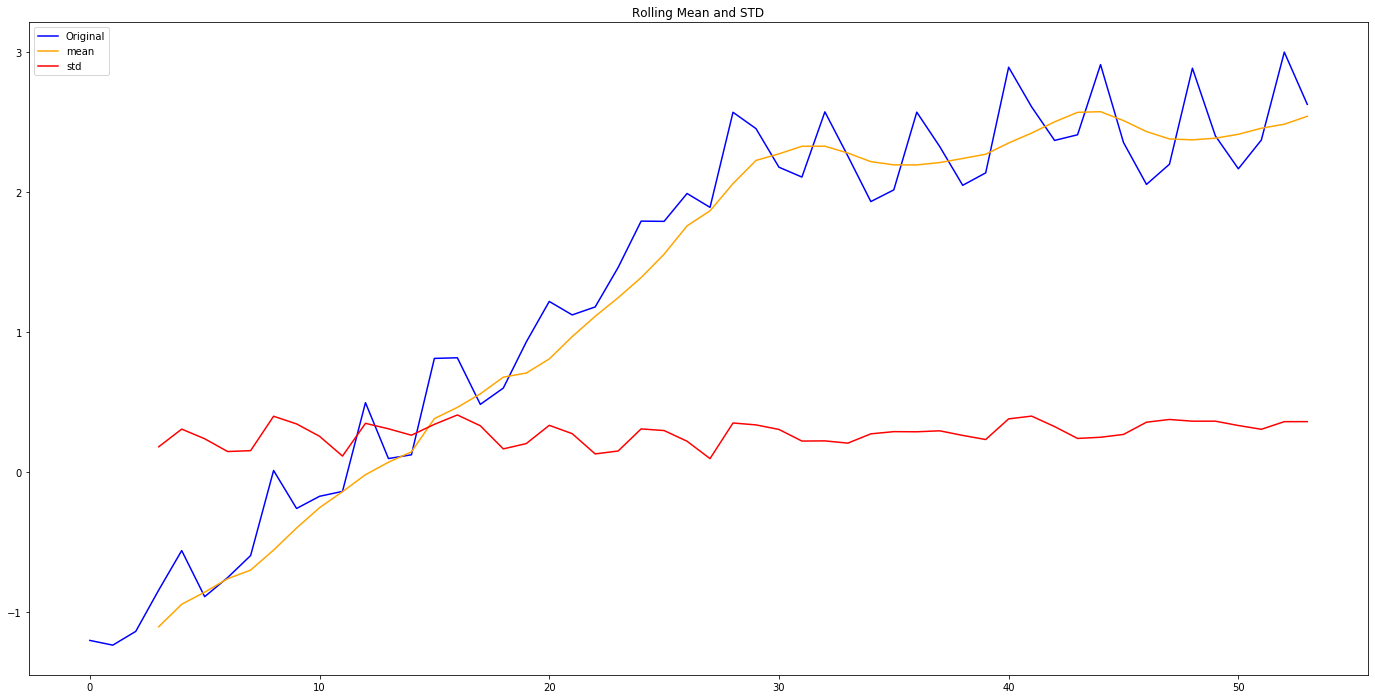

In [11]:
rolmean = train_df.rolling(window=4).mean()
rolstd = train_df.rolling(window=4).std()

orig = plt.plot(train_df.Umsatz, color='blue', label='Original')
mean = plt.plot(rolmean, color='orange', label='mean')
std = plt.plot(rolstd, color='red', label='std')
plt.legend(loc='best')
plt.title('Rolling Mean and STD')
plt.show()

## Automatisierte Suche nach bestem Modell (SARIMA)

In [12]:
decomposition = auto_arima(train_df.Umsatz, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=4,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 4); AIC=-14.871, BIC=-5.412, Fit time=0.097 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 4); AIC=-7.141, BIC=-3.358, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 4); AIC=-10.932, BIC=-3.365, Fit time=0.078 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 4); AIC=-16.627, BIC=-9.060, Fit time=0.061 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 4); AIC=-16.091, BIC=-6.632, Fit time=0.111 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 4); AIC=-9.253, BIC=-3.577, Fit time=0.026 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 4); AIC=-16.423, BIC=-6.964, Fit time=0.104 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 4); AIC=-14.567, BIC=-3.216, Fit time=0.203 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 4); AIC=-14.361, BIC=-8.686, Fit time=0.071 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 4); AIC=-15.43

In [13]:
decomposition.aic()

-16.62738746889217

## Fitten des Modells auf den Trainingsdatensatz

In [14]:
mod = sm.tsa.statespace.SARIMAX(train_df.Umsatz,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
decomposition = mod.fit()
#print(decomposition.summary())

In [15]:
#decomposition.plot_diagnostics(figsize=(15, 12))
#plt.show()

## Forcast und Visualisierung

In [16]:
# Get forecast ahead in future
pred_uc = decomposition.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

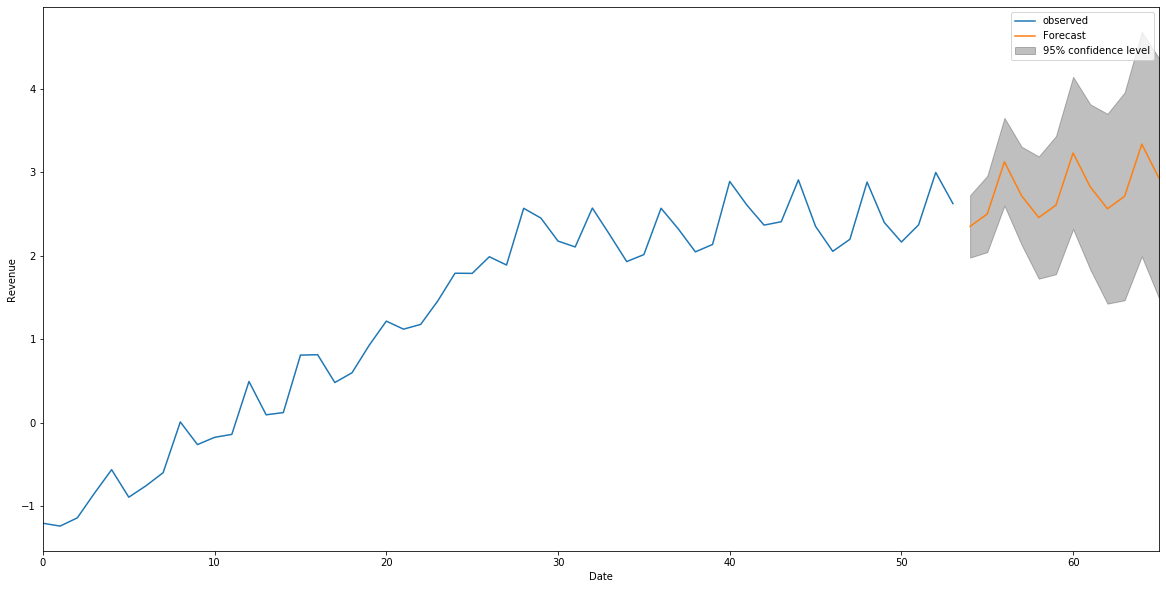

In [17]:
ax = train_df['Umsatz'].plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k',
                label='95% confidence level', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')

plt.legend()
plt.show()

In [18]:
pred_ci.head(6)

,lower Umsatz,upper Umsatz
54,1.979160,2.727292
55,2.044845,2.958215
56,2.600410,3.653400
57,2.131835,3.307987
58,1.726319,3.191707
59,1.779821,3.434813


In [19]:
forecast = decomposition.forecast(6)
forecast.head(6)

54    2.353226
55    2.501530
56    3.126905
57    2.719911
58    2.459013
59    2.607317
dtype: float64

## Forecast vs. historische Daten im Testdatensatz

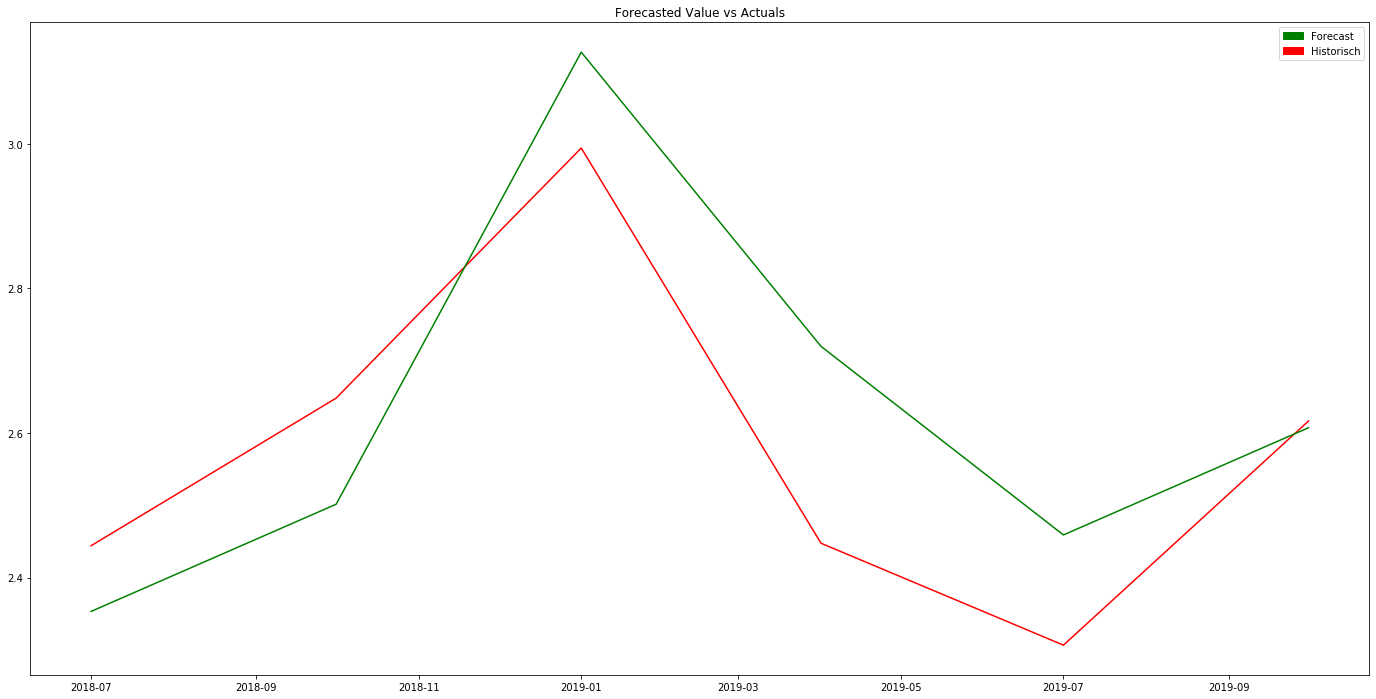

In [20]:
#----------------------------------------
# Forecast DataFrame und Original-DataFrame 

yActual = original_data.tail(6)['Umsatz'].values.tolist()
yPredicted = forecast.head(6).values.tolist()
periode = original_data.Periode.tail(6)

#----------------------------------------
# Plot Prognose vs. Original

plt.plot(periode,yActual, color='red') # Rot
plt.plot(periode,yPredicted, color='green') # Grün
green_patch = mpatches.Patch(color='green', label='Forecast') 
red_patch = mpatches.Patch(color='red', label='Historisch') 
plt.legend(handles=[green_patch, red_patch])
plt.title("Forecasted Value vs Actuals")
plt.show()

In [21]:
compare_df = pd.DataFrame()
compare_df['Period'] = original_data.Periode.tail(6)
compare_df['Umsatz_original'] = np.exp(yActual)
compare_df['Umsatz_Forecast'] = np.exp(yPredicted)
compare_df['PctChg'] = round(((compare_df.Umsatz_original - compare_df.Umsatz_Forecast) / compare_df.Umsatz_original * 100), 2)
compare_df

,Period,Umsatz_original,Umsatz_Forecast,PctChg
54,2018-07-01,11.52,10.519450,8.69
55,2018-10-01,14.13,12.201145,13.65
56,2019-01-01,19.97,22.803294,-14.19
57,2019-04-01,11.56,15.178966,-31.31
58,2019-07-01,10.04,11.693267,-16.47
59,2019-10-01,13.69,13.562614,0.93


In [22]:
compare_df.PctChg.mean()

-6.449999999999999

## Prognose für die nächsten 6 Quartale

In [23]:
periods_forcast = range(0,6)
x = forecast = decomposition.forecast(12)

forecast = pd.DataFrame({'Periode':periods_forcast, 'OOS-Forecast': np.exp(x[6:])})
forecast.head(6)

,Periode,OOS-Forecast
60,0,25.347809
61,1,16.872717
62,2,12.998065
63,3,15.076004
64,4,28.176254
65,5,18.755466


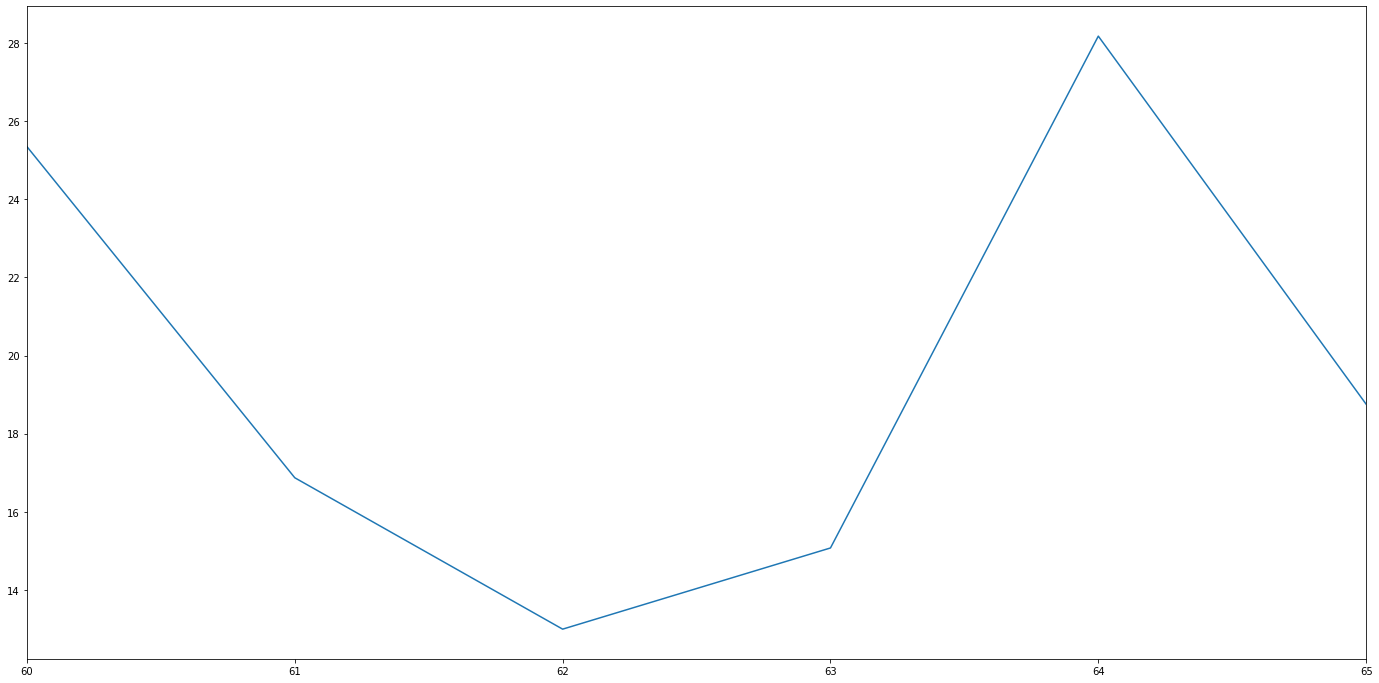

In [24]:
forecast['OOS-Forecast'].plot()